In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from grid_search_parallelized import GAN,Generator, Discriminator, Params
from utils import *
from tqdm import tqdm
import json
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
IMAGES_PATH = 'images/'

In [2]:

plt.rcParams['font.size'] = 15


## importing data

In [3]:
file_path = 'data_train_log_return.csv'
header = ["stock1", "stock2", "stock3", "stock4"]
df_train = pd.read_csv(file_path, header=None,index_col=0)
df_train.columns = header

In [4]:
print(df_train.describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
 & stock1 & stock2 & stock3 & stock4 \\
\midrule
count & 746.000000 & 746.000000 & 746.000000 & 746.000000 \\
mean & 0.013144 & 0.012822 & 0.009366 & 0.010788 \\
std & 0.011914 & 0.011712 & 0.009283 & 0.009338 \\
min & 0.000012 & 0.000057 & 0.000014 & 0.000067 \\
25% & 0.004761 & 0.003878 & 0.003202 & 0.004226 \\
50% & 0.010030 & 0.009423 & 0.006641 & 0.008508 \\
75% & 0.017771 & 0.017810 & 0.012354 & 0.014221 \\
max & 0.098709 & 0.088502 & 0.072016 & 0.074291 \\
\bottomrule
\end{tabular}



## plotting distribution and correlation matrix

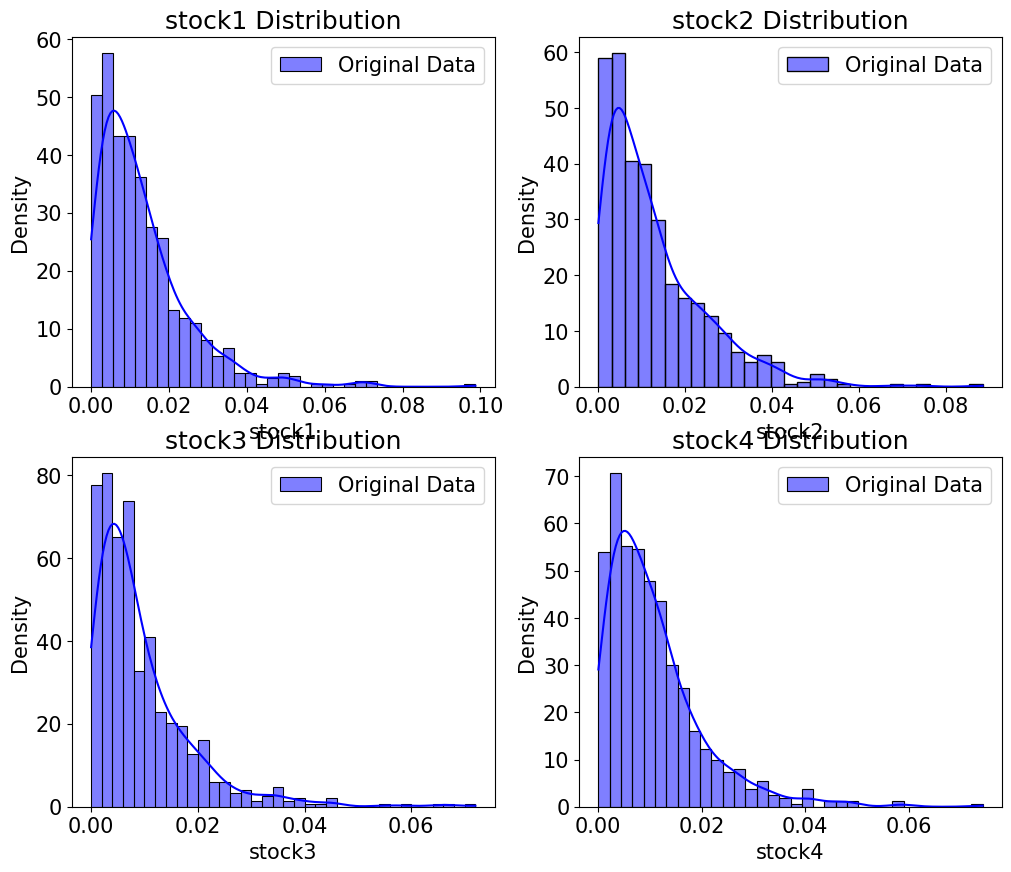

In [33]:
cov_matrix  = df_train.cov()
correlation_matrix = df_train.corr()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate through columns and plot for each subplot
for i, column_name in enumerate(df_train.columns):
    row_index = i // 2
    col_index = i % 2
    sns.histplot(df_train[column_name], kde=True, label='Original Data',stat = 'density', color='blue', alpha=0.5, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{column_name} Distribution')
    axes[row_index, col_index].set_xlabel(column_name)
    axes[row_index, col_index].legend()

  
fig.savefig(IMAGES_PATH+'true_data_distribution.png')

### correlation matrix

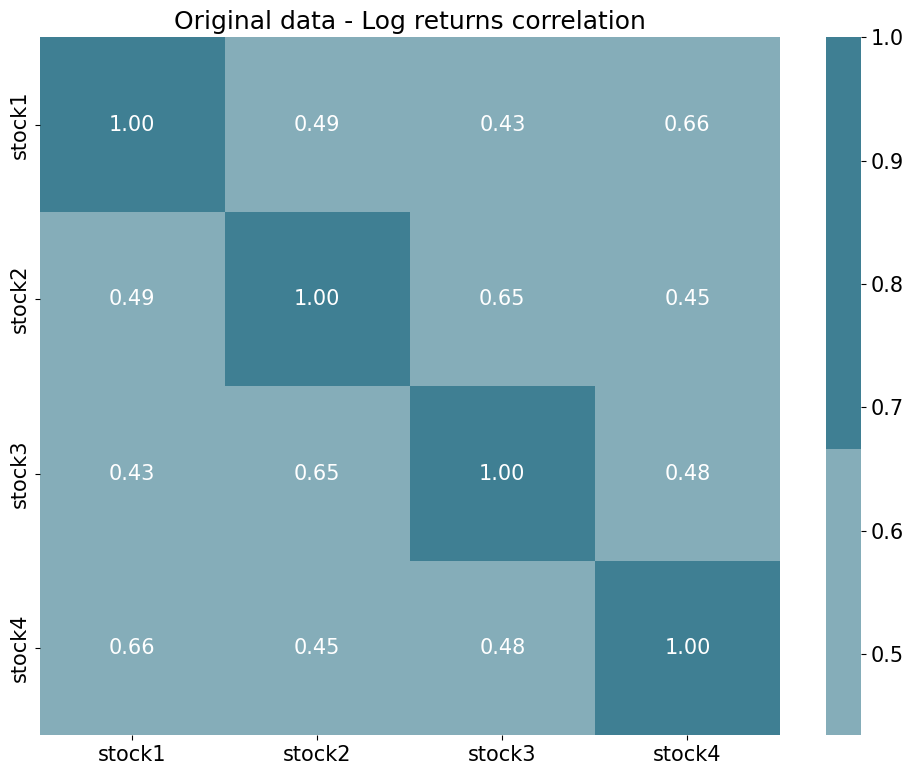

In [34]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, fmt='.2f', annot=True, cmap=sns.diverging_palette(h_neg=20, h_pos=220), center=0)
plt.title('Original data - Log returns correlation')
plt.tight_layout()

# Saving the plot
plt.savefig(IMAGES_PATH + 'true_data_correlation_matrix.png')

## 1. Analytical solution using cholesky decomposition 

In [35]:

synthetic_data = cholesky(df_train.shape[0],cov_matrix)
synthetic_data = pd.DataFrame(synthetic_data,columns = df_train.columns)
synthetic_data.head()

,stock1,stock2,stock3,stock4
0,0.010917,0.010491,0.017176,0.013005
1,0.021744,0.000492,0.016684,0.006002
2,0.003011,0.015052,0.010188,0.006143
3,0.005729,0.019441,0.019443,0.001577
4,0.003136,0.008148,0.007288,0.006307


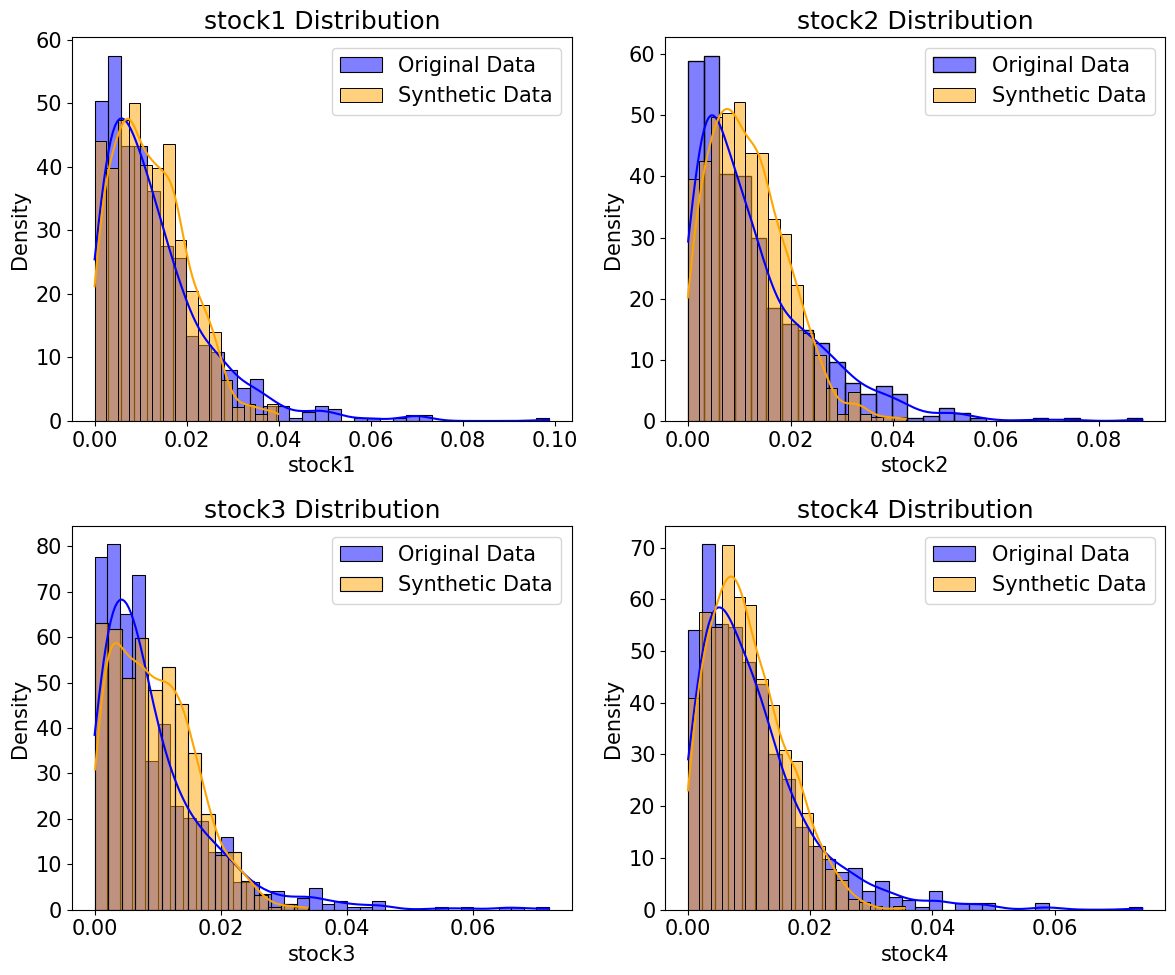

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate through columns and plot for each subplot
for i, column_name in enumerate(df_train.columns):
    row_index = i // 2
    col_index = i % 2
    sns.histplot(df_train[column_name], kde=True, label='Original Data',stat = 'density', color='blue', alpha=0.5, ax=axes[row_index, col_index])
    sns.histplot(synthetic_data[column_name], kde=True, label='Synthetic Data',stat = 'density', color='orange', alpha=0.5, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{column_name} Distribution')
    axes[row_index, col_index].set_xlabel(column_name)
    axes[row_index, col_index].legend()

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(IMAGES_PATH+'cholesky_synthetic_data')

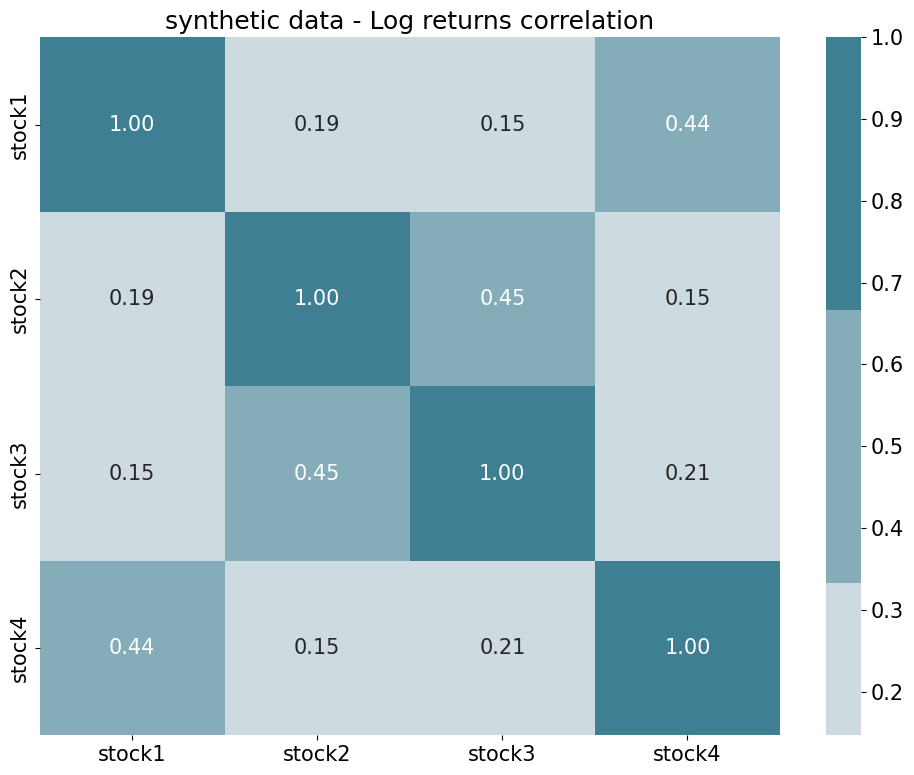

In [37]:

plt.figure(figsize=(10, 8))
sns.heatmap(synthetic_data.corr(), 
            fmt='.2f',
            annot=True,
            cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0).set(title='synthetic data - Log returns correlation')
plt.tight_layout()
# Saving the plot
plt.savefig(IMAGES_PATH + 'cholesky_synthetic_correlation_matrix.png')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axis array for easy iteration
axs = axs.ravel()

for i, column in enumerate(df_train.columns):
    # Compute CDFs
    x_train, y_train = compute_cdf(df_train[column])
    x_synthetic, y_synthetic = compute_cdf(synthetic_data[column])

    # Plot CDFs
    axs[i].plot(x_train, y_train, label='True Distribution', color='blue')
    axs[i].plot(x_synthetic, y_synthetic, label='Synthetic Distribution', color='red')

    axs[i].set_title(f'CDF of {column}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('CDF')
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.show()
fig.savefig(IMAGES_PATH + 'cholesky_cdf_synthetic_correlation_matrix.png')

In [39]:
ad = []
kendall = []
test_size = 410
for i in tqdm(range(200)):
    test_sample = df_train.sample(test_size)
    cov_matrix_sample = test_sample.cov()
    synthetic_data = cholesky(test_size,cov_matrix_sample)
    ad.append(AndersonDarling(test_sample.values,synthetic_data))
    kendall.append(kendall_tau_distance(pd.DataFrame(synthetic_data,columns =test_sample.columns),test_sample))



100%|██████████| 200/200 [01:11<00:00,  2.79it/s]


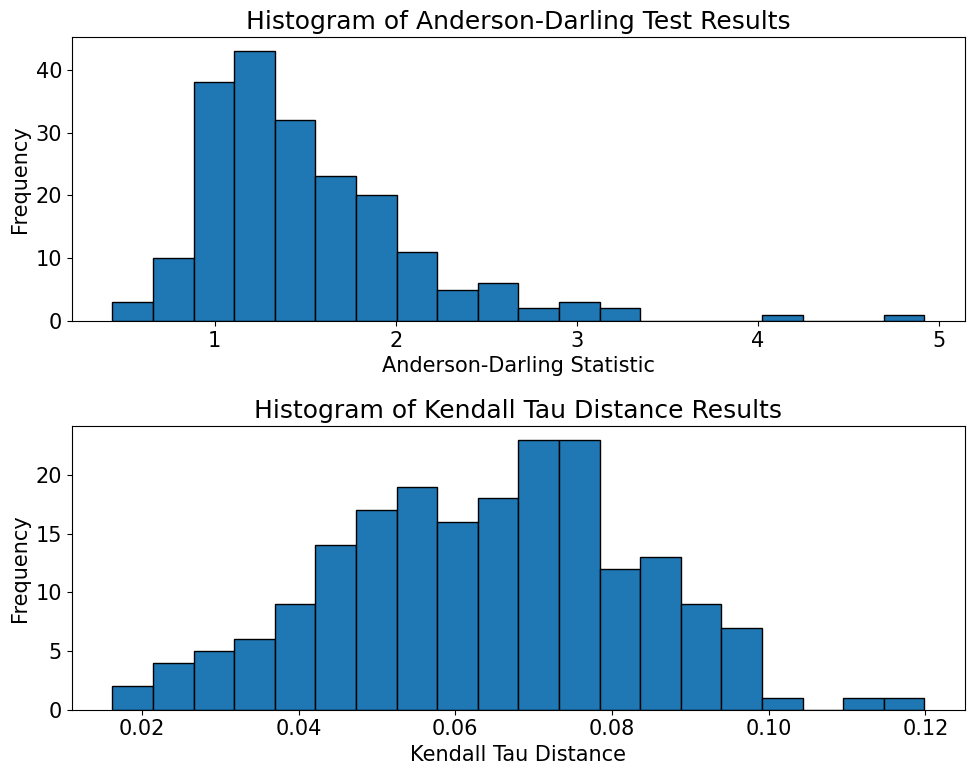

In [40]:

df = pd.DataFrame({'AndersonDarling': ad, 'Kendall': kendall})

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].hist(df['AndersonDarling'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of Anderson-Darling Test Results')
axes[0].set_xlabel('Anderson-Darling Statistic')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Kendall'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of Kendall Tau Distance Results')
axes[1].set_xlabel('Kendall Tau Distance')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


fig.savefig(IMAGES_PATH + 'cholesky_iterations_metrics')

In [41]:
print(df.describe().to_latex())

\begin{tabular}{lrr}
\toprule
 & AndersonDarling & Kendall \\
\midrule
count & 200.000000 & 200.000000 \\
mean & 1.521147 & 0.063962 \\
std & 0.615859 & 0.018951 \\
min & 0.434653 & 0.016224 \\
25% & 1.099616 & 0.049637 \\
50% & 1.374299 & 0.064378 \\
75% & 1.784606 & 0.076926 \\
max & 4.919981 & 0.119883 \\
\bottomrule
\end{tabular}



## 2. Gaussian mixture models

In [13]:
iterations = 200
n_components = 10
best_anderling = 1e6
best_kendall = 1e6
best_weights = None
for i in tqdm(range(iterations)):
    train, test = train_test_split(df_train, test_size=0.6, random_state=i)
    train.reset_index(drop=True,inplace=True)
    test.reset_index(drop=True,inplace=True)
    if best_weights is None :
        gmm = GaussianMixture(n_components=n_components,
                        covariance_type=  "full",
                        weights_init= best_weights)
    else :
        GaussianMixture(n_components=n_components,
                        covariance_type=  "full")
        
    gmm.fit(train)


    # Generating new samples
    synthetic_data,_  = gmm.sample(test.shape[0])  # Generate 10 new samples
    synthetic_data = pd.DataFrame(synthetic_data,columns = test.columns)
    distance = AndersonDarling(test.values, synthetic_data.values)
    kendall = kendall_tau_distance(test,synthetic_data)
    if distance < best_anderling:
        print('new best', distance)
        best_anderling = distance
        best_kendall = kendall
        best_weights = gmm.weights_


  0%|          | 1/200 [00:00<02:30,  1.33it/s]

new best 3.4506462005821135
new best 2.708501375355354


  2%|▏         | 4/200 [00:01<00:45,  4.26it/s]

new best 1.1043244347475536
new best 0.6772087292999487


  9%|▉         | 18/200 [00:03<00:27,  6.54it/s]

new best 0.586497155825171


 27%|██▋       | 54/200 [00:11<00:50,  2.87it/s]

new best 0.5405564379792622


 32%|███▏      | 63/200 [00:16<01:08,  2.01it/s]

new best 0.2808253942811092


100%|██████████| 200/200 [00:46<00:00,  4.29it/s]


In [ ]:
synthetic_data,_ = gmm.sample(df_train.shape[0])
synthetic_data = pd.DataFrame(synthetic_data,columns = df_train.columns.tolist())
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


axs = axs.ravel()

for i, column in enumerate(df_train.columns):

    x_train, y_train = compute_cdf(df_train[column])
    x_synthetic, y_synthetic = compute_cdf(synthetic_data[column])

    # Plot CDFs
    axs[i].plot(x_train, y_train, label='True Distribution', color='blue')
    axs[i].plot(x_synthetic, y_synthetic, label='Synthetic Distribution', color='red')

    axs[i].set_title(f'CDF of {column}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('CDF')
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.show()
fig.savefig(IMAGES_PATH + 'GMM_cdf_synthetic_correlation_matrix.png')

100%|██████████| 200/200 [00:10<00:00, 18.37it/s]


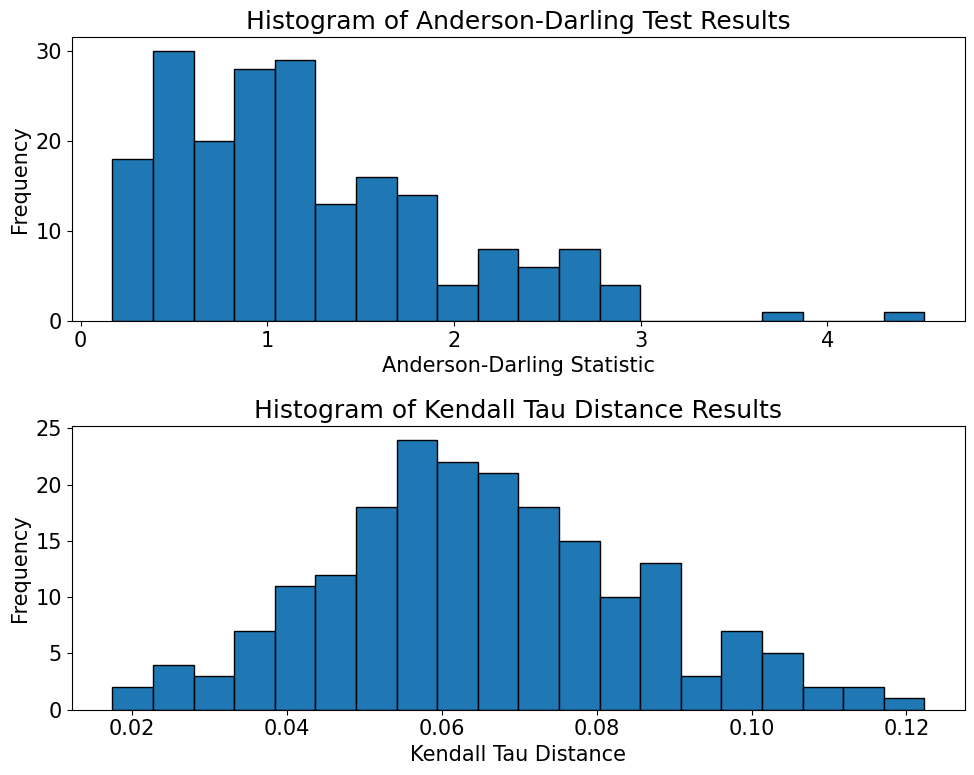

In [15]:
ad = []
kendall = []
test_size = 410
for i in tqdm(range(200)):
    test_sample = df_train.sample(test_size)
    synthetic_data,_ = gmm.sample(test_size)
    ad.append(AndersonDarling(synthetic_data,test_sample.values))
    kendall.append(kendall_tau_distance(pd.DataFrame(synthetic_data,columns =test_sample.columns),test_sample))

simulations = pd.DataFrame({'AndersonDarling':ad,'Kendall':kendall})
import matplotlib.pyplot as plt

df = pd.DataFrame({'AndersonDarling': ad, 'Kendall': kendall})
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))


axes[0].hist(df['AndersonDarling'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of Anderson-Darling Test Results')
axes[0].set_xlabel('Anderson-Darling Statistic')
axes[0].set_ylabel('Frequency')


axes[1].hist(df['Kendall'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of Kendall Tau Distance Results')
axes[1].set_xlabel('Kendall Tau Distance')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


fig.savefig(IMAGES_PATH + 'GMM_iterations_metrics')

In [16]:
print(df.describe().to_latex())

\begin{tabular}{lrr}
\toprule
 & AndersonDarling & Kendall \\
\midrule
count & 200.000000 & 200.000000 \\
mean & 1.219633 & 0.065480 \\
std & 0.736206 & 0.020026 \\
min & 0.170186 & 0.017467 \\
25% & 0.651728 & 0.052897 \\
50% & 1.069109 & 0.063767 \\
75% & 1.633829 & 0.079114 \\
max & 4.519083 & 0.122324 \\
\bottomrule
\end{tabular}



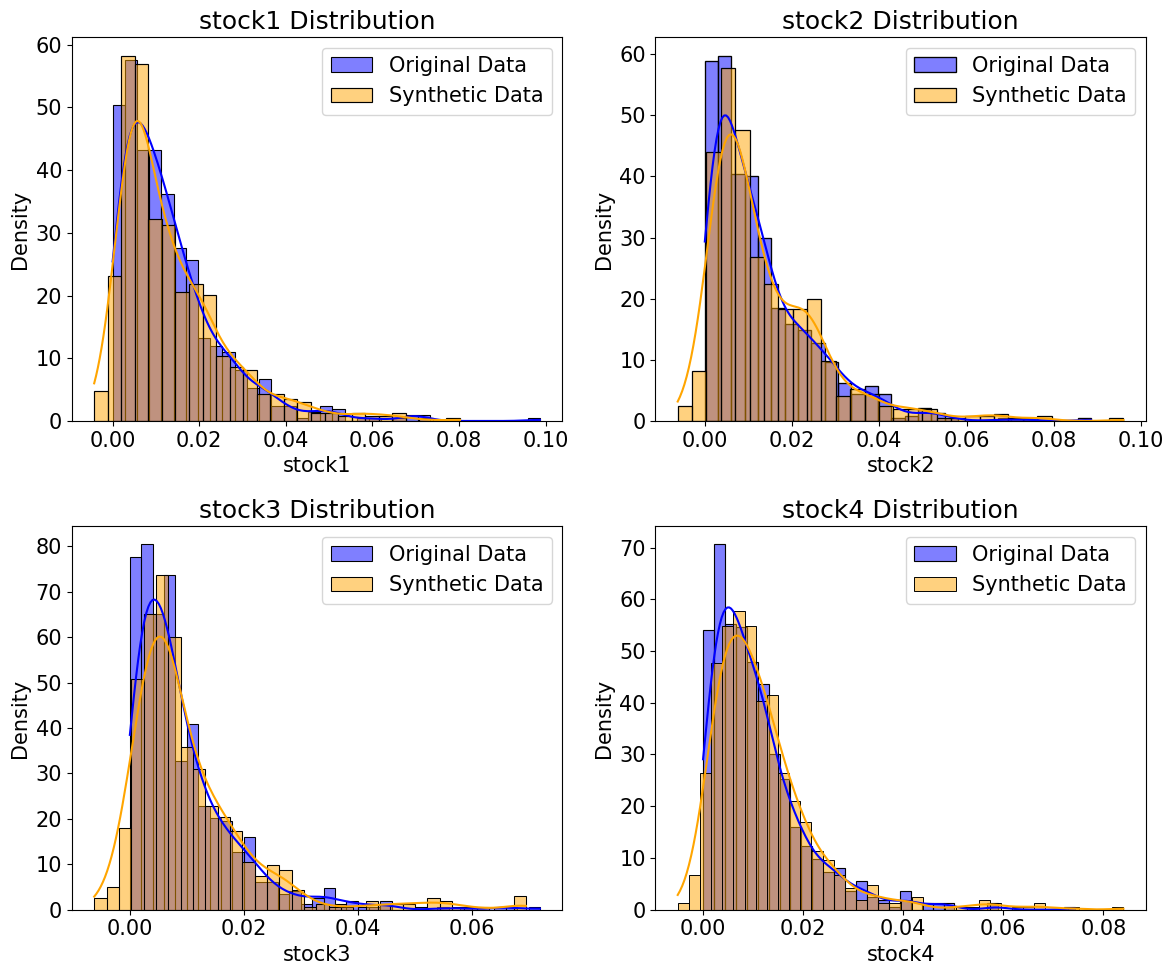

In [42]:

synthetic_data,_ = gmm.sample(df_train.shape[0])
synthetic_data = pd.DataFrame(synthetic_data,columns = df_train.columns)
feature_names = df_train.columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate through columns and plot for each subplot
for i, column_name in enumerate(df_train.columns):
    row_index = i // 2
    col_index = i % 2
    sns.histplot(df_train[column_name], kde=True, label='Original Data',stat = 'density', color='blue', alpha=0.5, ax=axes[row_index, col_index])
    sns.histplot(synthetic_data[column_name], kde=True, label='Synthetic Data',stat = 'density', color='orange', alpha=0.5, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{column_name} Distribution')
    axes[row_index, col_index].set_xlabel(column_name)
    axes[row_index, col_index].legend()

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(IMAGES_PATH+'GMM_synthetic_data')

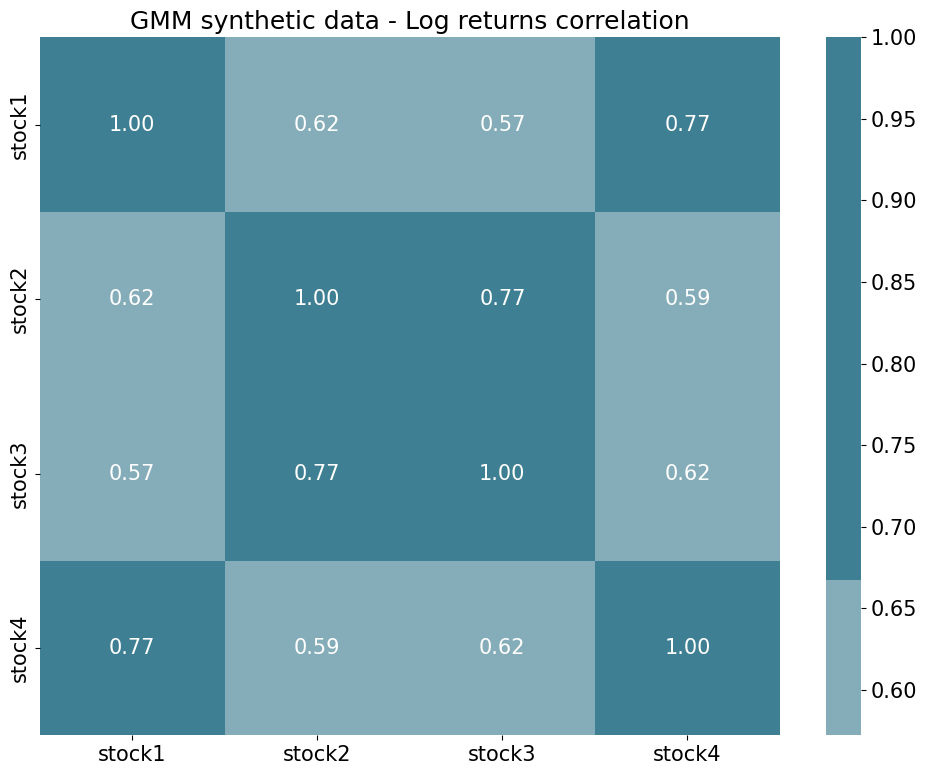

In [43]:

plt.figure(figsize=(10, 8))
sns.heatmap(synthetic_data.corr(), 
            fmt='.2f',
            annot=True,
            cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0).set(title='GMM synthetic data - Log returns correlation')
plt.tight_layout()
# Saving the plot
plt.savefig(IMAGES_PATH + 'GMM_synthetic_correlation_matrix.png')

In [44]:
print(synthetic_data.describe().to_latex())

\begin{tabular}{lrrrr}
\toprule
 & stock1 & stock2 & stock3 & stock4 \\
\midrule
count & 746.000000 & 746.000000 & 746.000000 & 746.000000 \\
mean & 0.013642 & 0.013966 & 0.010456 & 0.011954 \\
std & 0.012546 & 0.013349 & 0.011088 & 0.010703 \\
min & -0.004242 & -0.006151 & -0.006248 & -0.004992 \\
25% & 0.004780 & 0.004831 & 0.003874 & 0.005245 \\
50% & 0.009716 & 0.009675 & 0.007290 & 0.009614 \\
75% & 0.019171 & 0.020231 & 0.013919 & 0.015508 \\
max & 0.080242 & 0.095939 & 0.069548 & 0.084019 \\
\bottomrule
\end{tabular}



## 3. GAN Approach

this cell is to loop trhough all the simulation made by the grid search

In [22]:
def aggregate_results(results_dir='results'):
    all_results = []
    # Loop through each combination folder in the results directory
    for combi_name in tqdm(os.listdir(results_dir)):
        combi_dir = os.path.join(results_dir, combi_name)
        if os.path.isdir(combi_dir):
            csv_file = os.path.join(combi_dir, 'results.csv')
            if os.path.exists(csv_file):
                # Read the CSV file and append it to the list
                df = pd.read_csv(csv_file)
                df['Combination'] = combi_name  # Optionally, add a column indicating the combination
                all_results.append(df)

    # Concatenate all dataframes into one
    df =  pd.concat(all_results, ignore_index=True)
    df = df
    return df


results = aggregate_results('results').set_index('name')
results.to_csv('submission/grid_search_results.csv')
results.sample(frac =1)

,g_number_layer,g_number_neuron,g_hidden_activation,g_output_activation,d_number_layer,d_number_neuron,d_hidden_activation,d_output_activation,latent_dim,mean_anderling_distance,mean_kendall_tau,Combination
name,,,,,,,,,,,,
Generator_64_leaky_relu_64_leaky_relu_softplus_Discriminator_64_relu_softplus_LatentDim_20,2,"[64, 64]","['leaky_relu', 'leaky_relu']",softplus,1,[64],['relu'],softplus,20,6.436395,0.040912,Generator_64_leaky_relu_64_leaky_relu_softplus...
Generator_32_leaky_relu_32_leaky_relu_softplus_Discriminator_16_leaky_relu_softplus_LatentDim_20,2,"[32, 32]","['leaky_relu', 'leaky_relu']",softplus,1,[16],['leaky_relu'],softplus,20,33.534935,0.043557,Generator_32_leaky_relu_32_leaky_relu_softplus...
Generator_64_softplus_64_softplus_softplus_Discriminator_64_softplus_64_softplus_sigmoid_LatentDim_100,2,"[64, 64]","['softplus', 'softplus']",softplus,2,"[64, 64]","['softplus', 'softplus']",sigmoid,100,23.348586,0.047846,Generator_64_softplus_64_softplus_softplus_Dis...
Generator_64_softplus_softplus_Discriminator_32_relu_softplus_LatentDim_100,1,[64],['softplus'],softplus,1,[32],['relu'],softplus,100,20.554167,0.074567,Generator_64_softplus_softplus_Discriminator_3...
Generator_8_leaky_relu_8_leaky_relu_softplus_Discriminator_32_relu_softplus_LatentDim_20,2,"[8, 8]","['leaky_relu', 'leaky_relu']",softplus,1,[32],['relu'],softplus,20,17.940265,0.047373,Generator_8_leaky_relu_8_leaky_relu_softplus_D...
...,...,...,...,...,...,...,...,...,...,...,...,...
Generator_16_leaky_relu_16_leaky_relu_softplus_Discriminator_8_leaky_relu_softplus_LatentDim_20,2,"[16, 16]","['leaky_relu', 'leaky_relu']",softplus,1,[8],['leaky_relu'],softplus,20,34.244606,0.032046,Generator_16_leaky_relu_16_leaky_relu_softplus...
Generator_16_leaky_relu_16_leaky_relu_softplus_Discriminator_16_leaky_relu_sigmoid_LatentDim_20,2,"[16, 16]","['leaky_relu', 'leaky_relu']",softplus,1,[16],['leaky_relu'],sigmoid,20,21.139794,0.041019,Generator_16_leaky_relu_16_leaky_relu_softplus...
Generator_16_relu_softplus_Discriminator_16_relu_16_relu_16_relu_softplus_LatentDim_50,1,[16],['relu'],softplus,3,"[16, 16, 16]","['relu', 'relu', 'relu']",softplus,50,3.528704,0.066193,Generator_16_relu_softplus_Discriminator_16_re...


## Loading weights

best model params has been moved to the folder submission 

In [45]:
with open("submission/model_params.json", "r") as json_file:
    config = json.load(json_file)
    latent_dim = config['latent_dim']
    g_config = config['generator']
    d_config = config['discriminator']

config

{'generator': {'num_layers': 1,
  'neurons_per_layer': [16],
  'hidden_activation': ['relu'],
  'output_activation': 'softplus'},
 'discriminator': {'num_layers': 1,
  'neurons_per_layer': [64],
  'hidden_activation': ['leaky_relu'],
  'output_activation': 'sigmoid'},
 'latent_dim': 100}

In [46]:

opt = Params()  
opt.latent_dim = latent_dim 
opt.n_epochs =0 ## model weights are already trained

def generate_noise(n_samples):
    #  create toeplitz coovariance matrix
    covariance_matrix= 0.75 ** np.abs(np.subtract.outer ( np.arange(opt.latent_dim),np.arange (opt.latent_dim)))
    
    # selct noise
    noise = np.random.multivariate_normal(mean=np.zeros(opt.latent_dim),
                                            cov=covariance_matrix,
                                          size=n_samples)
    ## add square and cube of noise
    squared_noise = noise**2
    cube_noise = noise **3
    noise = np.concatenate([noise, squared_noise,cube_noise], axis=1)
    return noise

## build GAN
generator = Generator(latent_dim,output_shape = opt.shape_data, **g_config)

### load weigths
generator.model.load_weights('submission/generator_weights.h5')
discriminator = Discriminator(opt.shape_data,**d_config)
gan = GAN(generator,discriminator,opt)

In [47]:
noise = generate_noise(df_train.shape[0])
synthetic_data_gan = generator.model.predict(noise)
synthetic_data_gan = pd.DataFrame(synthetic_data_gan,columns = df_train.columns)
synthetic_data_gan

## ( predictions have to be divided by 100 as we fitted gan on df_train *100)

24/24 [==============================] - 0s 3ms/step


,stock1,stock2,stock3,stock4
0,3.893032,1.939176,1.295451,0.634217
1,4.027304,4.554160,0.605166,1.962209
2,0.661707,0.589842,0.682245,0.481672
3,4.162506,6.409490,0.165381,0.607060
4,1.278238,0.734691,0.235073,0.651780
...,...,...,...,...
741,0.589748,1.100919,0.143782,0.378685
742,1.012279,0.944013,0.755563,0.482425
743,8.506658,5.458112,0.524832,0.342375
744,2.182574,1.421211,0.169945,0.212437


In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Flatten the axis array for easy iteration
axs = axs.ravel()

for i, column in enumerate(df_train.columns):
    # Compute CDFs
    x_train, y_train = compute_cdf(df_train[column]*100)
    x_synthetic, y_synthetic = compute_cdf(synthetic_data_gan[column])

    # Plot CDFs
    axs[i].plot(x_train, y_train, label='True Distribution', color='blue')
    axs[i].plot(x_synthetic, y_synthetic, label='Synthetic Distribution', color='red')

    axs[i].set_title(f'CDF of {column}')
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('CDF')
    axs[i].legend()

# Adjust layout
fig.tight_layout()
fig.show()
fig.savefig(IMAGES_PATH + 'GAN_cdf_synthetic.png')

  0%|          | 0/200 [00:00<?, ?it/s]

13/13 [==============================] - 0s 3ms/step


  0%|          | 1/200 [00:00<01:37,  2.05it/s]

13/13 [==============================] - 0s 3ms/step


  1%|          | 2/200 [00:00<01:32,  2.13it/s]

13/13 [==============================] - 0s 3ms/step


  2%|▏         | 3/200 [00:01<01:34,  2.09it/s]

13/13 [==============================] - 0s 5ms/step


  2%|▏         | 4/200 [00:01<01:33,  2.10it/s]

13/13 [==============================] - 0s 5ms/step


  2%|▎         | 5/200 [00:02<01:40,  1.95it/s]

13/13 [==============================] - 0s 4ms/step


  3%|▎         | 6/200 [00:02<01:34,  2.05it/s]

13/13 [==============================] - 0s 3ms/step


  4%|▎         | 7/200 [00:03<01:30,  2.13it/s]

13/13 [==============================] - 0s 2ms/step


  4%|▍         | 8/200 [00:03<01:22,  2.33it/s]

13/13 [==============================] - 0s 3ms/step


  4%|▍         | 9/200 [00:03<01:13,  2.60it/s]

13/13 [==============================] - 0s 3ms/step


  5%|▌         | 10/200 [00:04<01:19,  2.39it/s]

13/13 [==============================] - 0s 5ms/step


  6%|▌         | 11/200 [00:05<01:27,  2.15it/s]

13/13 [==============================] - 0s 3ms/step


  6%|▌         | 12/200 [00:05<01:29,  2.09it/s]

13/13 [==============================] - 0s 3ms/step


  6%|▋         | 13/200 [00:05<01:23,  2.24it/s]

13/13 [==============================] - 0s 3ms/step


  7%|▋         | 14/200 [00:06<01:15,  2.47it/s]

13/13 [==============================] - 0s 3ms/step


  8%|▊         | 15/200 [00:06<01:14,  2.49it/s]

13/13 [==============================] - 0s 3ms/step


  8%|▊         | 16/200 [00:07<01:13,  2.51it/s]

13/13 [==============================] - 0s 2ms/step


  8%|▊         | 17/200 [00:07<01:06,  2.77it/s]

13/13 [==============================] - 0s 5ms/step


  9%|▉         | 18/200 [00:07<01:10,  2.59it/s]

13/13 [==============================] - 0s 3ms/step


 10%|▉         | 19/200 [00:08<01:06,  2.71it/s]

13/13 [==============================] - 0s 2ms/step


 10%|█         | 20/200 [00:08<01:02,  2.88it/s]

13/13 [==============================] - 0s 3ms/step


 10%|█         | 21/200 [00:08<01:02,  2.86it/s]

13/13 [==============================] - 0s 2ms/step


 11%|█         | 22/200 [00:08<00:57,  3.12it/s]

13/13 [==============================] - 0s 4ms/step


 12%|█▏        | 23/200 [00:09<00:57,  3.07it/s]

13/13 [==============================] - 0s 2ms/step


 12%|█▏        | 24/200 [00:09<00:53,  3.27it/s]

13/13 [==============================] - 0s 2ms/step


 12%|█▎        | 25/200 [00:09<00:50,  3.45it/s]

13/13 [==============================] - 0s 3ms/step


 13%|█▎        | 26/200 [00:10<00:51,  3.36it/s]

13/13 [==============================] - 0s 2ms/step


 14%|█▎        | 27/200 [00:10<00:48,  3.55it/s]

13/13 [==============================] - 0s 2ms/step


 14%|█▍        | 28/200 [00:10<00:46,  3.68it/s]

13/13 [==============================] - 0s 3ms/step


 14%|█▍        | 29/200 [00:10<00:50,  3.41it/s]

13/13 [==============================] - 0s 3ms/step


 15%|█▌        | 30/200 [00:11<00:55,  3.04it/s]

13/13 [==============================] - 0s 3ms/step


 16%|█▌        | 31/200 [00:11<00:58,  2.91it/s]

13/13 [==============================] - 0s 2ms/step


 16%|█▌        | 32/200 [00:12<00:57,  2.93it/s]

13/13 [==============================] - 0s 3ms/step


 16%|█▋        | 33/200 [00:12<00:55,  2.99it/s]

13/13 [==============================] - 0s 2ms/step


 17%|█▋        | 34/200 [00:12<00:53,  3.11it/s]

13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 35/200 [00:12<00:49,  3.33it/s]

13/13 [==============================] - 0s 3ms/step


 18%|█▊        | 36/200 [00:13<00:48,  3.39it/s]

13/13 [==============================] - 0s 2ms/step


 18%|█▊        | 37/200 [00:13<00:47,  3.46it/s]

13/13 [==============================] - 0s 2ms/step


 19%|█▉        | 38/200 [00:13<00:43,  3.73it/s]

13/13 [==============================] - 0s 2ms/step


 20%|█▉        | 39/200 [00:14<00:45,  3.52it/s]

13/13 [==============================] - 0s 2ms/step


 20%|██        | 40/200 [00:14<00:43,  3.65it/s]

13/13 [==============================] - 0s 2ms/step


 20%|██        | 41/200 [00:14<00:41,  3.87it/s]

13/13 [==============================] - 0s 2ms/step


 21%|██        | 42/200 [00:14<00:41,  3.85it/s]

13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 43/200 [00:15<00:40,  3.85it/s]

13/13 [==============================] - 0s 2ms/step


 22%|██▏       | 44/200 [00:15<00:39,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 22%|██▎       | 45/200 [00:15<00:37,  4.15it/s]

13/13 [==============================] - 0s 3ms/step


 23%|██▎       | 46/200 [00:15<00:39,  3.93it/s]

13/13 [==============================] - 0s 2ms/step


 24%|██▎       | 47/200 [00:16<00:37,  4.06it/s]

13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 48/200 [00:16<00:36,  4.13it/s]

13/13 [==============================] - 0s 2ms/step


 24%|██▍       | 49/200 [00:16<00:40,  3.75it/s]

13/13 [==============================] - 0s 2ms/step


 25%|██▌       | 50/200 [00:16<00:40,  3.73it/s]

13/13 [==============================] - 0s 3ms/step


 26%|██▌       | 51/200 [00:17<00:38,  3.85it/s]

13/13 [==============================] - 0s 3ms/step


 26%|██▌       | 52/200 [00:17<00:39,  3.75it/s]

13/13 [==============================] - 0s 2ms/step


 26%|██▋       | 53/200 [00:17<00:38,  3.83it/s]

13/13 [==============================] - 0s 2ms/step


 27%|██▋       | 54/200 [00:17<00:36,  3.96it/s]

13/13 [==============================] - 0s 3ms/step


 28%|██▊       | 55/200 [00:18<00:38,  3.76it/s]

13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 56/200 [00:18<00:40,  3.59it/s]

13/13 [==============================] - 0s 2ms/step


 28%|██▊       | 57/200 [00:18<00:40,  3.56it/s]

13/13 [==============================] - 0s 3ms/step


 29%|██▉       | 58/200 [00:19<00:40,  3.53it/s]

13/13 [==============================] - 0s 2ms/step


 30%|██▉       | 59/200 [00:19<00:38,  3.67it/s]

13/13 [==============================] - 0s 2ms/step


 30%|███       | 60/200 [00:19<00:36,  3.88it/s]

13/13 [==============================] - 0s 3ms/step


 30%|███       | 61/200 [00:19<00:35,  3.91it/s]

13/13 [==============================] - 0s 2ms/step


 31%|███       | 62/200 [00:19<00:34,  4.00it/s]

13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 63/200 [00:20<00:33,  4.14it/s]

13/13 [==============================] - 0s 2ms/step


 32%|███▏      | 64/200 [00:20<00:32,  4.23it/s]

13/13 [==============================] - 0s 5ms/step


 32%|███▎      | 65/200 [00:20<00:34,  3.91it/s]

13/13 [==============================] - 0s 2ms/step


 33%|███▎      | 66/200 [00:21<00:34,  3.88it/s]

13/13 [==============================] - 0s 2ms/step


 34%|███▎      | 67/200 [00:21<00:32,  4.08it/s]

13/13 [==============================] - 0s 2ms/step


 34%|███▍      | 68/200 [00:21<00:31,  4.22it/s]

13/13 [==============================] - 0s 3ms/step


 34%|███▍      | 69/200 [00:21<00:31,  4.10it/s]

13/13 [==============================] - 0s 2ms/step


 35%|███▌      | 70/200 [00:21<00:31,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 71/200 [00:22<00:31,  4.14it/s]

13/13 [==============================] - 0s 2ms/step


 36%|███▌      | 72/200 [00:22<00:31,  4.01it/s]

13/13 [==============================] - 0s 3ms/step


 36%|███▋      | 73/200 [00:22<00:31,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 37%|███▋      | 74/200 [00:22<00:31,  4.05it/s]

13/13 [==============================] - 0s 3ms/step


 38%|███▊      | 75/200 [00:23<00:31,  3.99it/s]

13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 76/200 [00:23<00:30,  4.01it/s]

13/13 [==============================] - 0s 2ms/step


 38%|███▊      | 77/200 [00:23<00:29,  4.22it/s]

13/13 [==============================] - 0s 2ms/step


 39%|███▉      | 78/200 [00:23<00:27,  4.37it/s]

13/13 [==============================] - 0s 3ms/step


 40%|███▉      | 79/200 [00:24<00:29,  4.06it/s]

13/13 [==============================] - 0s 2ms/step


 40%|████      | 80/200 [00:24<00:29,  4.08it/s]

13/13 [==============================] - 0s 2ms/step


 40%|████      | 81/200 [00:24<00:29,  4.07it/s]

13/13 [==============================] - 0s 2ms/step


 41%|████      | 82/200 [00:24<00:28,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 83/200 [00:25<00:29,  3.94it/s]

13/13 [==============================] - 0s 2ms/step


 42%|████▏     | 84/200 [00:25<00:28,  4.04it/s]

13/13 [==============================] - 0s 2ms/step


 42%|████▎     | 85/200 [00:25<00:27,  4.19it/s]

13/13 [==============================] - 0s 2ms/step


 43%|████▎     | 86/200 [00:25<00:28,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 44%|████▎     | 87/200 [00:26<00:30,  3.65it/s]

13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 88/200 [00:26<00:30,  3.68it/s]

13/13 [==============================] - 0s 2ms/step


 44%|████▍     | 89/200 [00:26<00:30,  3.59it/s]

13/13 [==============================] - 0s 2ms/step


 45%|████▌     | 90/200 [00:27<00:29,  3.70it/s]

13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 91/200 [00:27<00:27,  3.90it/s]

13/13 [==============================] - 0s 2ms/step


 46%|████▌     | 92/200 [00:27<00:26,  4.06it/s]

13/13 [==============================] - 0s 2ms/step


 46%|████▋     | 93/200 [00:27<00:27,  3.83it/s]

13/13 [==============================] - 0s 2ms/step


 47%|████▋     | 94/200 [00:27<00:26,  4.01it/s]

13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 95/200 [00:28<00:25,  4.12it/s]

13/13 [==============================] - 0s 3ms/step


 48%|████▊     | 96/200 [00:28<00:27,  3.82it/s]

13/13 [==============================] - 0s 2ms/step


 48%|████▊     | 97/200 [00:28<00:26,  3.90it/s]

13/13 [==============================] - 0s 2ms/step


 49%|████▉     | 98/200 [00:28<00:25,  3.97it/s]

13/13 [==============================] - 0s 3ms/step


 50%|████▉     | 99/200 [00:29<00:25,  3.96it/s]

13/13 [==============================] - 0s 2ms/step


 50%|█████     | 100/200 [00:29<00:25,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 50%|█████     | 101/200 [00:29<00:23,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 51%|█████     | 102/200 [00:29<00:23,  4.15it/s]

13/13 [==============================] - 0s 3ms/step


 52%|█████▏    | 103/200 [00:30<00:24,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 52%|█████▏    | 104/200 [00:30<00:24,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 52%|█████▎    | 105/200 [00:30<00:22,  4.17it/s]

13/13 [==============================] - 0s 2ms/step


 53%|█████▎    | 106/200 [00:30<00:22,  4.22it/s]

13/13 [==============================] - 0s 4ms/step


 54%|█████▎    | 107/200 [00:31<00:23,  3.94it/s]

13/13 [==============================] - 0s 2ms/step


 54%|█████▍    | 108/200 [00:31<00:22,  4.13it/s]

13/13 [==============================] - 0s 2ms/step


 55%|█████▍    | 109/200 [00:31<00:21,  4.27it/s]

13/13 [==============================] - 0s 2ms/step


 55%|█████▌    | 110/200 [00:31<00:21,  4.21it/s]

13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 111/200 [00:32<00:22,  4.04it/s]

13/13 [==============================] - 0s 2ms/step


 56%|█████▌    | 112/200 [00:32<00:20,  4.21it/s]

13/13 [==============================] - 0s 2ms/step


 56%|█████▋    | 113/200 [00:32<00:19,  4.37it/s]

13/13 [==============================] - 0s 2ms/step


 57%|█████▋    | 114/200 [00:32<00:21,  4.02it/s]

13/13 [==============================] - 0s 2ms/step


 57%|█████▊    | 115/200 [00:33<00:21,  4.02it/s]

13/13 [==============================] - 0s 2ms/step


 58%|█████▊    | 116/200 [00:33<00:20,  4.15it/s]

13/13 [==============================] - 0s 3ms/step


 58%|█████▊    | 117/200 [00:33<00:20,  4.10it/s]

13/13 [==============================] - 0s 2ms/step


 59%|█████▉    | 118/200 [00:33<00:20,  4.09it/s]

13/13 [==============================] - 0s 2ms/step


 60%|█████▉    | 119/200 [00:34<00:19,  4.25it/s]

13/13 [==============================] - 0s 2ms/step


 60%|██████    | 120/200 [00:34<00:19,  4.16it/s]

13/13 [==============================] - 0s 2ms/step


 60%|██████    | 121/200 [00:34<00:19,  3.99it/s]

13/13 [==============================] - 0s 2ms/step


 61%|██████    | 122/200 [00:34<00:19,  4.05it/s]

13/13 [==============================] - 0s 2ms/step


 62%|██████▏   | 123/200 [00:35<00:18,  4.16it/s]

13/13 [==============================] - 0s 3ms/step


 62%|██████▏   | 124/200 [00:35<00:20,  3.80it/s]

13/13 [==============================] - 0s 2ms/step


 62%|██████▎   | 125/200 [00:35<00:18,  3.98it/s]

13/13 [==============================] - 0s 2ms/step


 63%|██████▎   | 126/200 [00:35<00:18,  4.02it/s]

13/13 [==============================] - 0s 2ms/step


 64%|██████▎   | 127/200 [00:36<00:20,  3.52it/s]

13/13 [==============================] - 0s 2ms/step


 64%|██████▍   | 128/200 [00:36<00:20,  3.60it/s]

13/13 [==============================] - 0s 3ms/step


 64%|██████▍   | 129/200 [00:36<00:19,  3.69it/s]

13/13 [==============================] - 0s 2ms/step


 65%|██████▌   | 130/200 [00:37<00:19,  3.53it/s]

13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 131/200 [00:37<00:19,  3.61it/s]

13/13 [==============================] - 0s 2ms/step


 66%|██████▌   | 132/200 [00:37<00:18,  3.74it/s]

13/13 [==============================] - 0s 2ms/step


 66%|██████▋   | 133/200 [00:37<00:17,  3.86it/s]

13/13 [==============================] - 0s 2ms/step


 67%|██████▋   | 134/200 [00:38<00:16,  3.89it/s]

13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 135/200 [00:38<00:16,  4.01it/s]

13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 136/200 [00:38<00:15,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 68%|██████▊   | 137/200 [00:38<00:15,  3.99it/s]

13/13 [==============================] - 0s 2ms/step


 69%|██████▉   | 138/200 [00:39<00:15,  4.02it/s]

13/13 [==============================] - 0s 2ms/step


 70%|██████▉   | 139/200 [00:39<00:14,  4.09it/s]

13/13 [==============================] - 0s 2ms/step


 70%|███████   | 140/200 [00:39<00:14,  4.14it/s]

13/13 [==============================] - 0s 2ms/step


 70%|███████   | 141/200 [00:39<00:15,  3.88it/s]

13/13 [==============================] - 0s 2ms/step


 71%|███████   | 142/200 [00:40<00:14,  3.95it/s]

13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 143/200 [00:40<00:13,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 72%|███████▏  | 144/200 [00:40<00:13,  4.29it/s]

13/13 [==============================] - 0s 2ms/step


 72%|███████▎  | 145/200 [00:40<00:13,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 73%|███████▎  | 146/200 [00:40<00:13,  4.06it/s]

13/13 [==============================] - 0s 2ms/step


 74%|███████▎  | 147/200 [00:41<00:12,  4.20it/s]

13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 148/200 [00:41<00:12,  4.20it/s]

13/13 [==============================] - 0s 2ms/step


 74%|███████▍  | 149/200 [00:41<00:12,  4.10it/s]

13/13 [==============================] - 0s 2ms/step


 75%|███████▌  | 150/200 [00:41<00:12,  4.14it/s]

13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 151/200 [00:42<00:11,  4.30it/s]

13/13 [==============================] - 0s 2ms/step


 76%|███████▌  | 152/200 [00:42<00:11,  4.21it/s]

13/13 [==============================] - 0s 2ms/step


 76%|███████▋  | 153/200 [00:42<00:10,  4.28it/s]

13/13 [==============================] - 0s 2ms/step


 77%|███████▋  | 154/200 [00:42<00:11,  4.17it/s]

13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 155/200 [00:43<00:10,  4.33it/s]

13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 156/200 [00:43<00:10,  4.02it/s]

13/13 [==============================] - 0s 2ms/step


 78%|███████▊  | 157/200 [00:43<00:10,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 79%|███████▉  | 158/200 [00:43<00:09,  4.26it/s]

13/13 [==============================] - 0s 2ms/step


 80%|███████▉  | 159/200 [00:44<00:09,  4.26it/s]

13/13 [==============================] - 0s 2ms/step


 80%|████████  | 160/200 [00:44<00:09,  4.12it/s]

13/13 [==============================] - 0s 2ms/step


 80%|████████  | 161/200 [00:44<00:09,  4.12it/s]

13/13 [==============================] - 0s 2ms/step


 81%|████████  | 162/200 [00:44<00:10,  3.65it/s]

13/13 [==============================] - 0s 3ms/step


 82%|████████▏ | 163/200 [00:45<00:10,  3.62it/s]

13/13 [==============================] - 0s 2ms/step


 82%|████████▏ | 164/200 [00:45<00:09,  3.79it/s]

13/13 [==============================] - 0s 2ms/step


 82%|████████▎ | 165/200 [00:45<00:08,  4.00it/s]

13/13 [==============================] - 0s 2ms/step


 83%|████████▎ | 166/200 [00:45<00:08,  4.10it/s]

13/13 [==============================] - 0s 2ms/step


 84%|████████▎ | 167/200 [00:46<00:08,  3.94it/s]

13/13 [==============================] - 0s 3ms/step


 84%|████████▍ | 168/200 [00:46<00:08,  3.92it/s]

13/13 [==============================] - 0s 2ms/step


 84%|████████▍ | 169/200 [00:46<00:07,  4.11it/s]

13/13 [==============================] - 0s 2ms/step


 85%|████████▌ | 170/200 [00:46<00:07,  3.96it/s]

13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 171/200 [00:47<00:07,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 86%|████████▌ | 172/200 [00:47<00:06,  4.15it/s]

13/13 [==============================] - 0s 2ms/step


 86%|████████▋ | 173/200 [00:47<00:06,  4.27it/s]

13/13 [==============================] - 0s 2ms/step


 87%|████████▋ | 174/200 [00:47<00:06,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 175/200 [00:48<00:06,  3.77it/s]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 176/200 [00:48<00:06,  3.72it/s]

13/13 [==============================] - 0s 2ms/step


 88%|████████▊ | 177/200 [00:48<00:05,  3.89it/s]

13/13 [==============================] - 0s 2ms/step


 89%|████████▉ | 178/200 [00:48<00:05,  3.97it/s]

13/13 [==============================] - 0s 2ms/step


 90%|████████▉ | 179/200 [00:49<00:05,  4.00it/s]

13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 180/200 [00:49<00:05,  3.87it/s]

13/13 [==============================] - 0s 2ms/step


 90%|█████████ | 181/200 [00:49<00:04,  3.98it/s]

13/13 [==============================] - 0s 3ms/step


 91%|█████████ | 182/200 [00:49<00:04,  3.94it/s]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 183/200 [00:50<00:04,  3.73it/s]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▏| 184/200 [00:50<00:04,  3.78it/s]

13/13 [==============================] - 0s 2ms/step


 92%|█████████▎| 185/200 [00:50<00:03,  3.79it/s]

13/13 [==============================] - 0s 2ms/step


 93%|█████████▎| 186/200 [00:51<00:03,  3.66it/s]

13/13 [==============================] - 0s 2ms/step


 94%|█████████▎| 187/200 [00:51<00:03,  3.71it/s]

13/13 [==============================] - 0s 2ms/step


 94%|█████████▍| 188/200 [00:51<00:03,  3.95it/s]

13/13 [==============================] - 0s 3ms/step


 94%|█████████▍| 189/200 [00:51<00:02,  3.94it/s]

13/13 [==============================] - 0s 2ms/step


 95%|█████████▌| 190/200 [00:51<00:02,  4.03it/s]

13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 191/200 [00:52<00:02,  4.25it/s]

13/13 [==============================] - 0s 2ms/step


 96%|█████████▌| 192/200 [00:52<00:01,  4.20it/s]

13/13 [==============================] - 0s 2ms/step


 96%|█████████▋| 193/200 [00:52<00:01,  3.76it/s]

13/13 [==============================] - 0s 2ms/step


 97%|█████████▋| 194/200 [00:53<00:01,  3.91it/s]

13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 195/200 [00:53<00:01,  3.78it/s]

13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 196/200 [00:53<00:01,  3.75it/s]

13/13 [==============================] - 0s 2ms/step


 98%|█████████▊| 197/200 [00:53<00:00,  3.90it/s]

13/13 [==============================] - 0s 4ms/step


 99%|█████████▉| 198/200 [00:54<00:00,  3.88it/s]

13/13 [==============================] - 0s 2ms/step


100%|█████████▉| 199/200 [00:54<00:00,  3.79it/s]

13/13 [==============================] - 0s 2ms/step


100%|██████████| 200/200 [00:54<00:00,  3.66it/s]


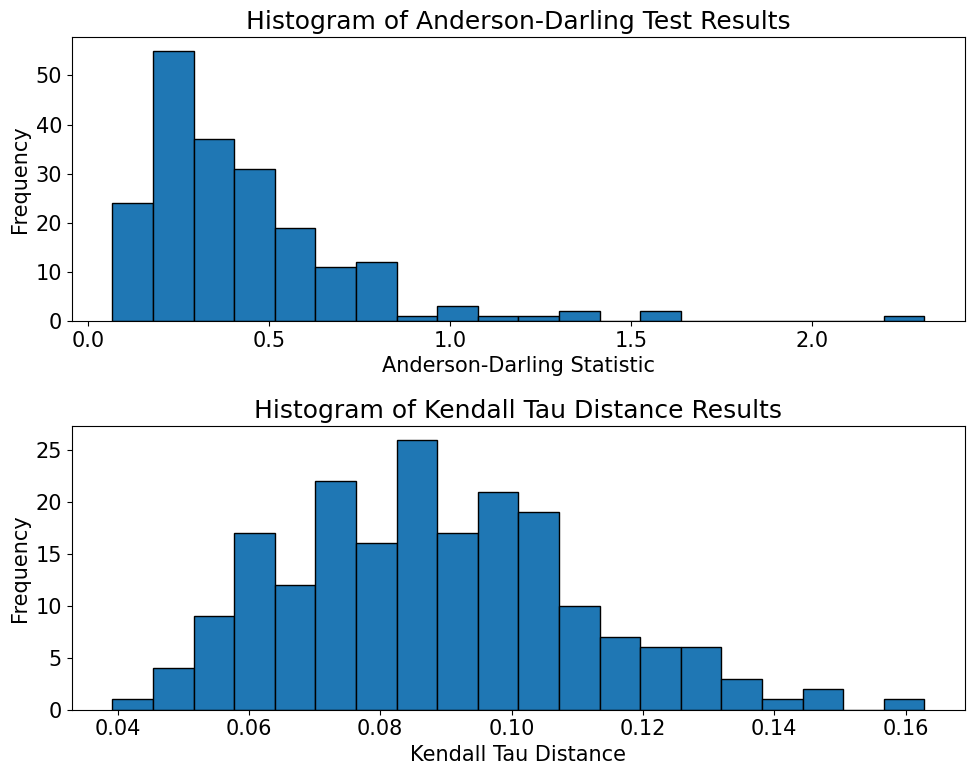

In [49]:
ad = []
kendall = []
test_size = 410
for i in tqdm(range(200)):
    test_sample = df_train.sample(test_size) *100
    noise = generate_noise(test_size)
    synthetic_data = generator.model.predict(noise)
    ad.append(AndersonDarling(test_sample.values,synthetic_data))
    kendall.append(kendall_tau_distance(pd.DataFrame(synthetic_data,columns =test_sample.columns),test_sample))

simulations = pd.DataFrame({'AndersonDarling':ad,'Kendall':kendall})
import matplotlib.pyplot as plt

df = pd.DataFrame({'AndersonDarling': ad, 'Kendall': kendall})

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axes[0].hist(df['AndersonDarling'], bins=20, edgecolor='black')
axes[0].set_title('Histogram of Anderson-Darling Test Results')
axes[0].set_xlabel('Anderson-Darling Statistic')
axes[0].set_ylabel('Frequency')

axes[1].hist(df['Kendall'], bins=20, edgecolor='black')
axes[1].set_title('Histogram of Kendall Tau Distance Results')
axes[1].set_xlabel('Kendall Tau Distance')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


fig.savefig(IMAGES_PATH + 'GAN_iterations_metrics')

In [51]:
print(df.describe().to_latex())

\begin{tabular}{lrr}
\toprule
 & AndersonDarling & Kendall \\
\midrule
count & 200.000000 & 200.000000 \\
mean & 0.428039 & 0.088514 \\
std & 0.298841 & 0.022480 \\
min & 0.066944 & 0.039216 \\
25% & 0.240877 & 0.072494 \\
50% & 0.339624 & 0.087447 \\
75% & 0.526102 & 0.102222 \\
max & 2.309868 & 0.162861 \\
\bottomrule
\end{tabular}



24/24 [==============================] - 0s 1ms/step


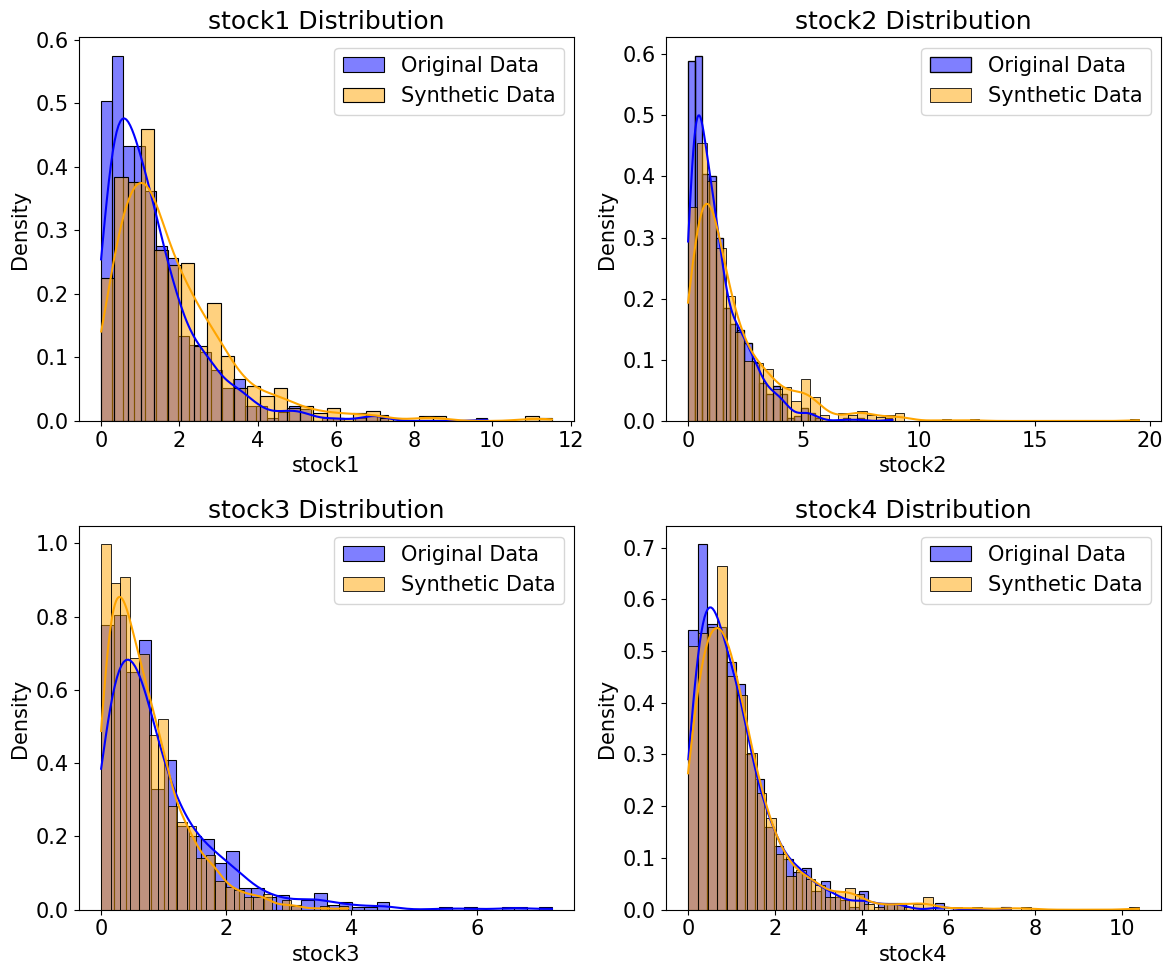

In [31]:
noise = generate_noise(df_train.shape[0])
synthetic_data_gan = generator.model.predict(noise)
synthetic_data_gan = pd.DataFrame(synthetic_data_gan,columns = df_train.columns)
synthetic_data_gan
feature_names = df_train.columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Iterate through columns and plot for each subplot
for i, column_name in enumerate(df_train.columns):
    row_index = i // 2
    col_index = i % 2
    sns.histplot(df_train[column_name]*100, kde=True, label='Original Data',stat = 'density', color='blue', alpha=0.5, ax=axes[row_index, col_index])
    sns.histplot(synthetic_data_gan[column_name], kde=True, label='Synthetic Data',stat = 'density', color='orange', alpha=0.5, ax=axes[row_index, col_index])
    axes[row_index, col_index].set_title(f'{column_name} Distribution')
    axes[row_index, col_index].set_xlabel(column_name)
    axes[row_index, col_index].legend()

# Adjust layout
plt.tight_layout()
plt.show()
fig.savefig(IMAGES_PATH+'GAN_synthetic_data')

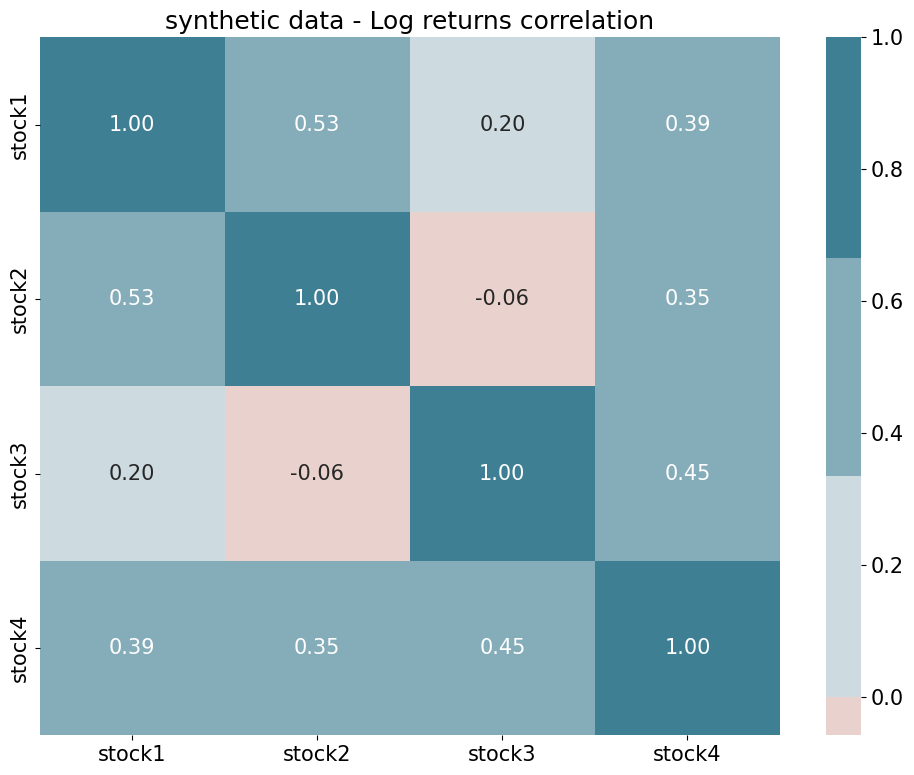

In [32]:

plt.figure(figsize=(10, 8))
sns.heatmap(synthetic_data_gan.corr(), 
            fmt='.2f',
            annot=True,
            cmap=sns.diverging_palette(h_neg=20,
                                          h_pos=220), center=0).set(title='synthetic data - Log returns correlation')
plt.tight_layout()
# Saving the plot
plt.savefig(IMAGES_PATH + 'GAN_synthetic_correlation_matrix.png')

## Generating submission files

13/13 [==============================] - 0s 2ms/step


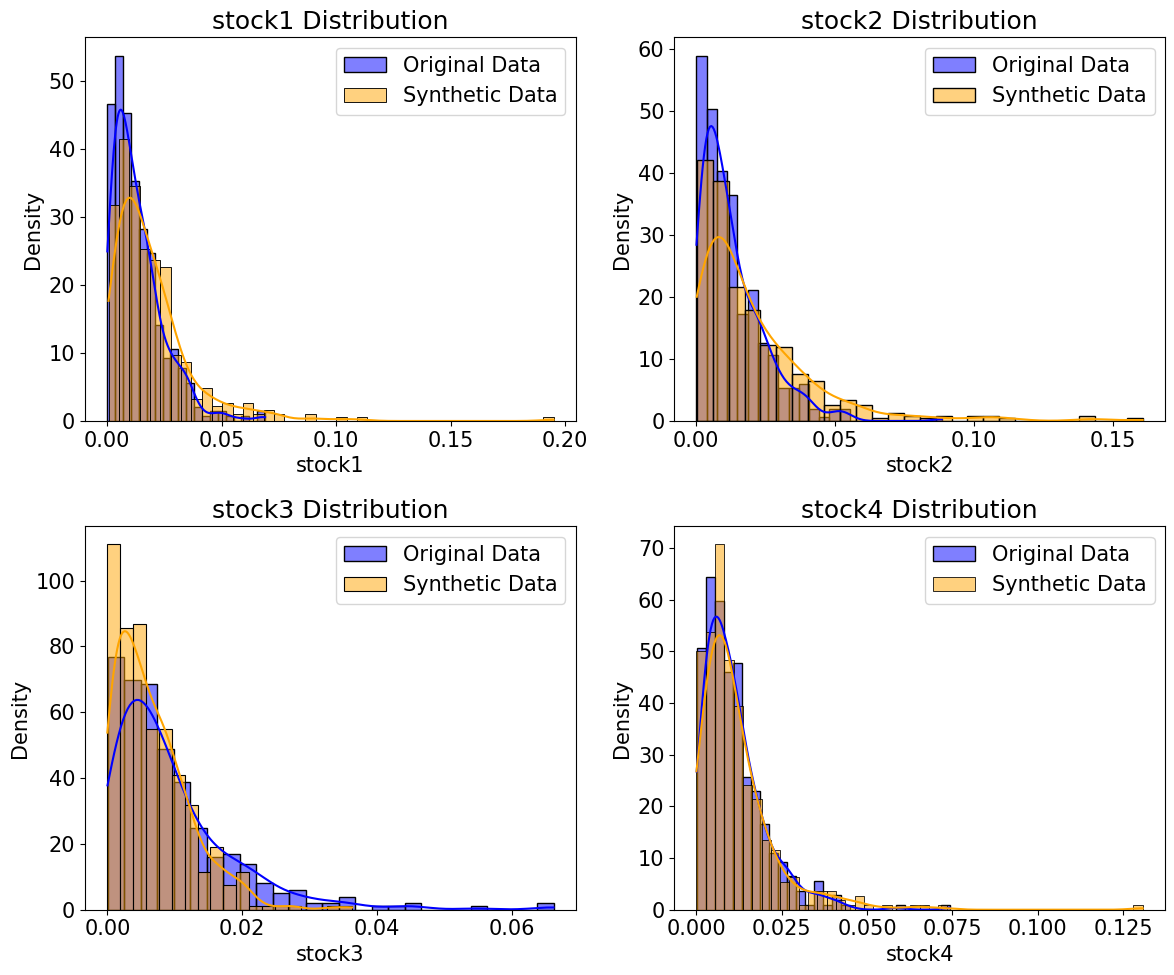

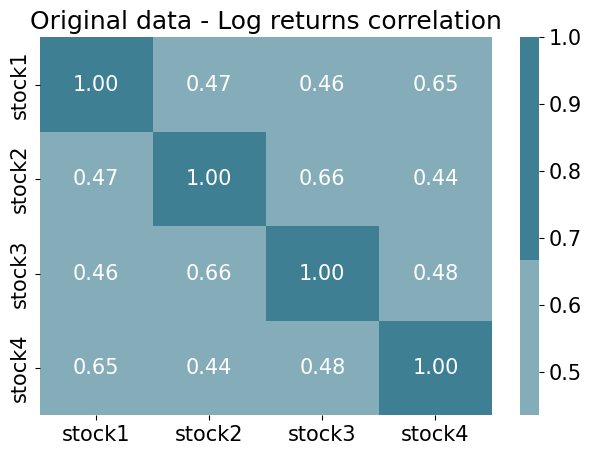

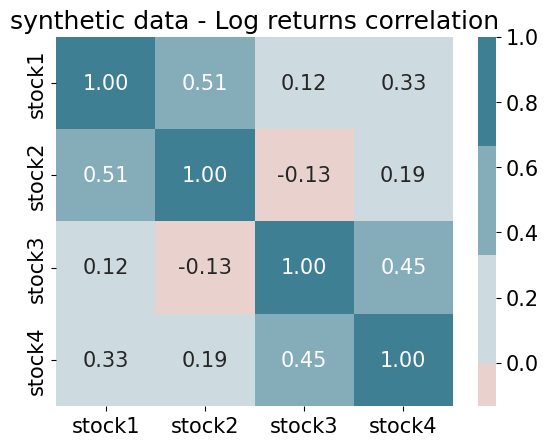

In [38]:
n2 = 410
noise = generate_noise(n2)
synthetic_data_gan = generator.model.predict(noise)
synthetic_data_gan = pd.DataFrame(synthetic_data_gan,columns = df_train.columns) /100
compare(synthetic_data_gan,df_train.sample(n2))

In [39]:
noise = pd.DataFrame(noise)
noise.to_csv('submission/noise.csv')
noise.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.600958,0.857978,-0.150096,-0.839802,-0.359595,-1.172619,-0.467489,-0.752552,-1.069884,-2.148184,...,-0.000945,-0.044199,0.082533,0.104776,1.131705,4.431998,9.669082,0.396794,3.772489,9.776165
1,-0.078875,0.104354,-0.298759,-0.463367,-0.516009,0.643449,0.993091,0.696587,0.624005,-0.126561,...,0.840163,0.010244,-0.007526,0.177489,0.004632,-0.046726,-0.547520,-0.739378,0.059385,-0.071088
2,-0.735694,0.752021,0.722778,0.471210,0.880679,0.020387,0.935408,0.670332,0.438327,-0.120052,...,0.996157,0.389997,15.953318,2.833356,0.047842,0.188850,1.040188,0.043821,-0.829220,-0.000144
3,0.628793,-0.163677,-0.681570,-0.679395,-2.129884,-1.376614,-2.202002,-0.610705,0.004673,1.034494,...,-9.307067,-22.741524,-2.161593,-1.135541,-0.207718,-0.099911,0.000016,1.036824,0.369605,0.006448
4,0.471067,0.873767,1.468364,0.367518,-0.178579,0.307964,1.015684,-0.039280,-1.037170,0.528332,...,-0.007447,-3.298966,-2.333332,-1.640679,-4.122751,-3.006203,-0.710387,-0.221461,-0.000010,0.000074


In [40]:
synthetic_data_gan.to_csv('submission/synthetic_data.csv')

### Reproducing results

In [41]:
file_path = 'data_train_log_return.csv'
header = ["stock1", "stock2", "stock3", "stock4"]
df_train = pd.read_csv(file_path, header=None,index_col=0)
df_train.columns = header


with open("submission/model_params.json", "r") as json_file:
    config = json.load(json_file)
    latent_dim = config['latent_dim']
    g_config = config['generator']
    d_config = config['discriminator']

opt = Params()  # Assuming Params is a class that contains other GAN parameters
opt.latent_dim = latent_dim 
opt.n_epochs =0 ## model weights are already trained

def generate_noise(n_samples):
    covariance_matrix= 0.75 ** np.abs(np.subtract.outer ( np.arange(opt.latent_dim),np.arange (opt.latent_dim)))
    noise = np.random.multivariate_normal(mean=np.zeros(opt.latent_dim),
                                            cov=covariance_matrix,
                                            size=n_samples)
    squared_noise = noise**2
    cube_noise = noise **3
    noise = np.concatenate([noise, squared_noise,cube_noise], axis=1)
    return noise

## build GAN
generator = Generator(latent_dim,output_shape = opt.shape_data, **g_config)

### load weigths
generator.model.load_weights('submission/generator_weights.h5')
discriminator = Discriminator(opt.shape_data,**d_config)
gan = GAN(generator,discriminator,opt)


### import noise
noise = pd.read_csv('submission/noise.csv',index_col=0)
noise = noise.values
synthetic_data = generator.model.predict(noise)
synthetic_data = pd.DataFrame(synthetic_data,columns = df_train.columns) /100
synthetic_data

13/13 [==============================] - 0s 3ms/step


,stock1,stock2,stock3,stock4
0,0.036150,0.027986,0.005762,0.004549
1,0.064053,0.015040,0.000003,0.000020
2,0.009923,0.015208,0.003571,0.016866
3,0.012089,0.029192,0.003707,0.013426
4,0.016696,0.044588,0.000811,0.011752
...,...,...,...,...
405,0.002982,0.003131,0.010109,0.006859
406,0.006606,0.015269,0.004344,0.010647
407,0.009417,0.015617,0.009077,0.012411
408,0.008333,0.003379,0.005192,0.010587
